In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression
from sklearn.decomposition import PCA

sns.set()
warnings.filterwarnings('ignore')

In [24]:
train_logs = pd.read_csv('input/train_logs.csv')
train_scores = pd.read_csv('input/train_scores.csv')
train_logs.head(2)

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0


In [37]:
train_logs.groupby(['down_event'])['event_id'].agg('count').sort_values(ascending=False)[20:40]

down_event
;              1785
=              1155
Tab            1081
/               874
Rightclick      655
:               634
(               611
)               578
\               554
ContextMenu     552
End             547
!               546
Meta            479
Alt             466
[               369
c               359
v               311
NumLock         273
Insert          226
Home            221
Name: event_id, dtype: int64

In [68]:
essays = pd.DataFrame()
essays['id'] = train_scores['id']
essays['score'] = train_scores['score']
g = train_logs.groupby(['id'])['event_id'].agg('count')
essays['total_events'] = g.values

events = train_logs.groupby(['down_event'])['event_id'].agg('count').sort_values(ascending=False).index[:40]
g = train_logs.groupby(['id', 'down_event']).count().unstack(fill_value=0).stack()
for event in events:
    essays[event + '_freq'] =  g[g.index.get_level_values('down_event') == event]['event_id'].values / essays['total_events']
essays.head(2)

,id,score,total_events,q_freq,Space_freq,Backspace_freq,Shift_freq,ArrowRight_freq,Leftclick_freq,ArrowLeft_freq,...,End_freq,!_freq,Meta_freq,Alt_freq,[_freq,c_freq,v_freq,NumLock_freq,Insert_freq,Home_freq
0,001519c8,3.5,2557,0.633164,0.139617,0.163082,0.010559,0.000782,0.03598,0.000782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0022f953,3.5,2454,0.607172,0.159332,0.105949,0.039527,0.018745,0.02282,0.019967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
data = pd.DataFrame()
data_cols = [event + '_freq' for event in events] + ['total_events']
data['features'] = data_cols
data['VIF'] = [variance_inflation_factor(essays[data_cols], i).round(1) for i in range(essays[data_cols].shape[1])]
f_scores, p_scores = f_regression(essays[data_cols], essays['score'])
data['Fscores'] = f_scores.round(0)
data['Pscores'] = p_scores.round(5)
data = data.sort_values(by='Fscores', ascending=False)
data

,features,VIF,Fscores,Pscores
40,total_events,8.5,1324.0,0.00000
8,",_freq",5.1,467.0,0.00000
18,-_freq,1.5,153.0,0.00000
7,._freq,9.2,149.0,0.00000
1,Space_freq,17.8,82.0,0.00000
26,(_freq,9.2,79.0,0.00000
5,Leftclick_freq,1.6,69.0,0.00000
12,CapsLock_freq,1.2,67.0,0.00000
17,"""_freq",1.5,65.0,0.00000
27,)_freq,9.1,58.0,0.00000


In [79]:
features = [',', '-', '.', '(', 'Leftclick', 'CapsLock', '"', '?', "'", '\\', 'Enter']
data_cols = [f + '_freq' for f in features] + ['total_events']

data = pd.DataFrame()
data['features'] = data_cols
data['VIF'] = [variance_inflation_factor(essays[data_cols], i).round(1) for i in range(essays[data_cols].shape[1])]
f_scores, p_scores = f_regression(essays[data_cols], essays['score'])
data['Fscores'] = f_scores.round(0)
data['Pscores'] = p_scores.round(5)
data = data.sort_values(by='Fscores', ascending=False)
data

,features,VIF,Fscores,Pscores
11,total_events,4.0,1324.0,0.0
0,",_freq",4.4,467.0,0.0
1,-_freq,1.5,153.0,0.0
2,._freq,4.0,149.0,0.0
3,(_freq,1.3,79.0,0.0
4,Leftclick_freq,1.5,69.0,0.0
5,CapsLock_freq,1.1,67.0,0.0
6,"""_freq",1.5,65.0,0.0
7,?_freq,1.4,48.0,0.0
8,'_freq,2.1,47.0,0.0


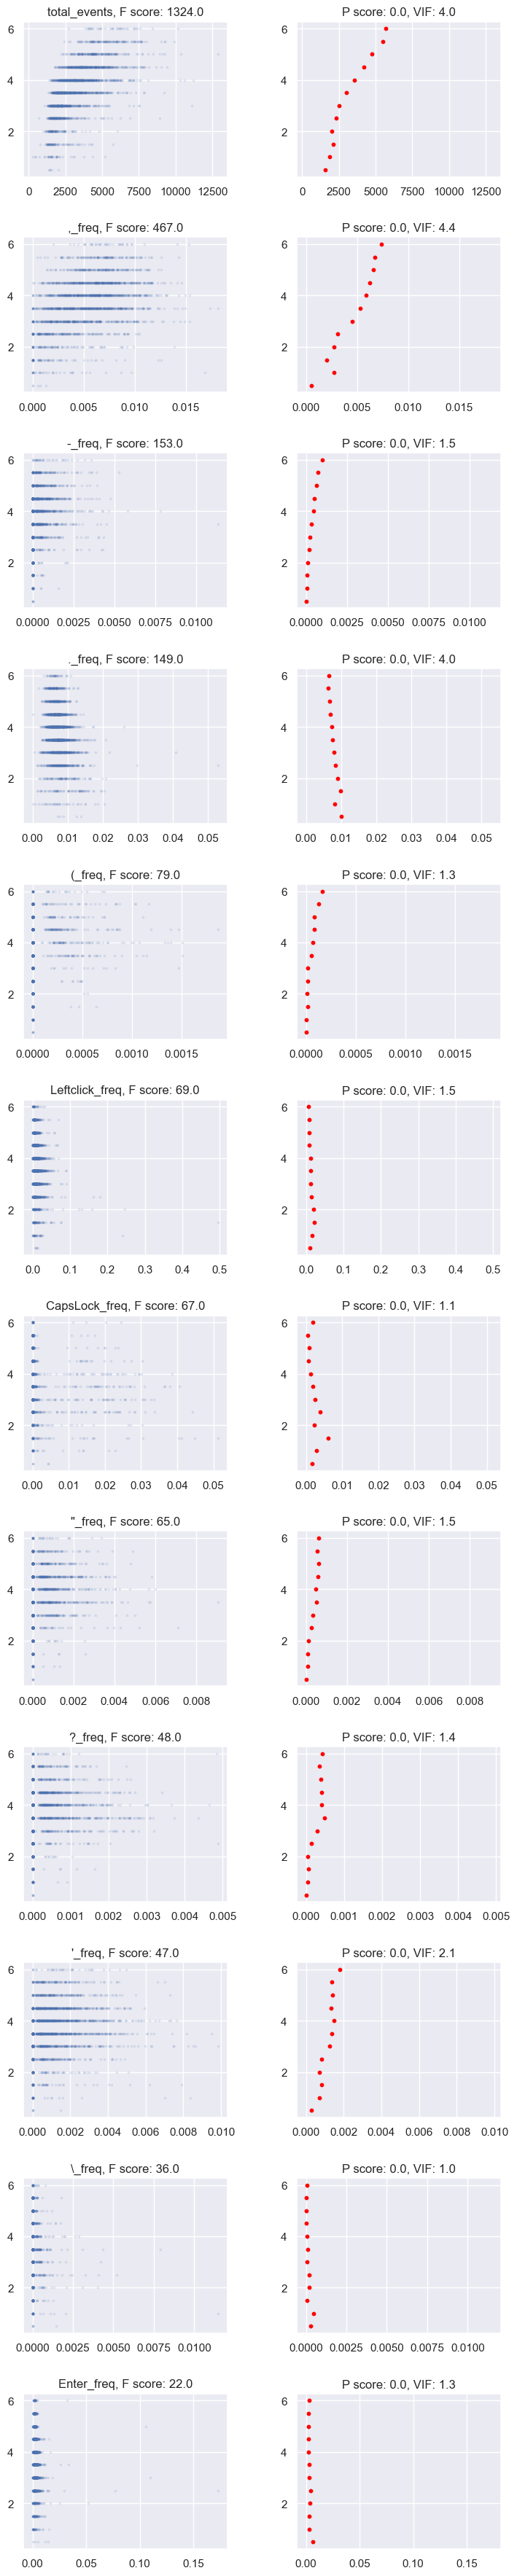

In [82]:
n = len(data_cols)
fig, axs = plt.subplots(ncols=2, nrows=n, figsize=(8, 3 * n), sharex='row')
fig.tight_layout(pad=3.0)

for i in range(n):
    col = data['features'].iloc[i]
    g = essays.groupby('score')[col].agg('mean')
    axs[i, 0].scatter(essays[col], essays['score'], s=3, alpha=.1)
    axs[i, 0].title.set_text(col + ', F score: ' + str(data['Fscores'].iloc[i]))
    axs[i, 1].scatter(g, g.index, s=10, color='red')
    axs[i, 1].title.set_text('P score: ' + str(data['Pscores'].iloc[i]) + ', VIF: ' + str(data['VIF'].iloc[i]) )

In [83]:
X, y = essays[data_cols], essays['score']
X_train_and_valid, X_test, y_train_and_valid, y_test = train_test_split(X, y, test_size=.2, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_and_valid, y_train_and_valid, test_size=.25, random_state=0)

In [84]:
def round_scores(scores):
    scores = ((scores * 2) // 1) * .5
    scores = np.where(scores < 0, 0.0, scores)
    scores = np.where(scores > 6, 6.0, scores)
    return scores

In [88]:
params = {'max_depth': [2, 8, 15], 
          'min_samples_leaf': [3, 5, 8],
         'n_estimators': [50, 100, 200]}
model = RandomForestRegressor()
gs = GridSearchCV(estimator=model, 
                           param_grid=params,
                           scoring='neg_root_mean_squared_error',
                           cv=3)
gs.fit(X_train, y_train)
results = gs.cv_results_
print('Best Score:', gs.best_score_, 'Best Params:', gs.best_params_)

Best Score: -0.7241367312339039 Best Params: {'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 50}


MAE: training set
0.6148466778368112
MAE: validation set
0.7886466653407193


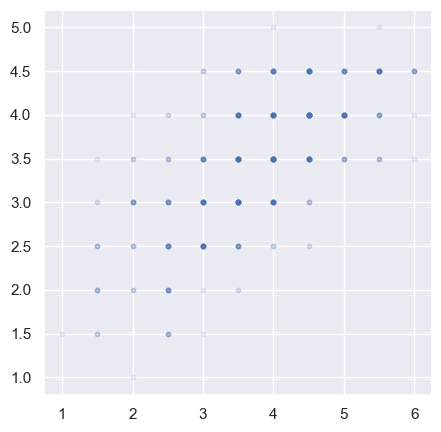

In [95]:
model = RandomForestRegressor(max_depth=8, min_samples_leaf=5, n_estimators=50)
model.fit(X_train, y_train)
y_predict_train = round_scores(model.predict(X_train))
y_predict_valid = round_scores(model.predict(X_valid))
print('MAE: training set')
print(mean_squared_error(y_train, y_predict_train, squared=False))
print('MAE: validation set')
print(mean_squared_error(y_valid, y_predict_valid, squared=False))
plt.figure(figsize=(5,5))
plt.scatter(y_valid, y_predict_valid, s=10, alpha=.1);

In [96]:
params = {'n_estimators': [50, 100, 200],  
              'max_depth': [2, 5, 13], 
              'min_samples_leaf': [3, 5, 8],
              'learning_rate': [.1],
             'subsample': [.8, 1]} 
model = GradientBoostingRegressor()
gs = GridSearchCV(estimator=model, 
                           param_grid=params,
                           scoring='neg_root_mean_squared_error',
                           cv=3)
gs.fit(X_train, y_train)
results = gs.cv_results_
print('Best Score:', gs.best_score_, 'Best Params:', gs.best_params_)

Best Score: -0.7152874514305289 Best Params: {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 3, 'n_estimators': 100, 'subsample': 0.8}


MAE: training set
0.6844375726267604
MAE: validation set
0.7789617298161821


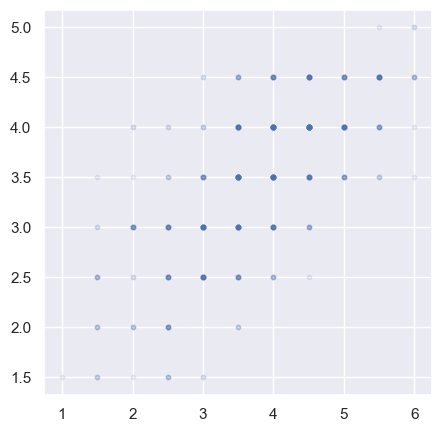

In [97]:
model = GradientBoostingRegressor(max_depth=2, min_samples_leaf=3, n_estimators=100, learning_rate=.1, subsample=.8)
model.fit(X_train, y_train)
y_predict_train = round_scores(model.predict(X_train))
y_predict_valid = round_scores(model.predict(X_valid))
print('MAE: training set')
print(mean_squared_error(y_train, y_predict_train, squared=False))
print('MAE: validation set')
print(mean_squared_error(y_valid, y_predict_valid, squared=False))
plt.figure(figsize=(5,5))
plt.scatter(y_valid, y_predict_valid, s=10, alpha=.1);